**Bert Model by Copilot**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


212/212 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - accuracy: 0.2012 - loss: 2.0940 - val_accuracy: 0.1904 - val_loss: 1.6120
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.2040 - loss: 1.7562 - val_accuracy: 0.2096 - val_loss: 1.6145
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.2040 - loss: 1.6628 - val_accuracy: 0.2113 - val_loss: 1.6101
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.2232 - loss: 1.6185 - val_accuracy: 0.2240 - val_loss: 1.6023
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.2752 - loss: 1.5692 - val_accuracy: 0.2668 - val_loss: 1.5743
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.4032 - loss: 1.3690 - val_accuracy: 0.3238 - val_loss: 1.5449
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.5659 - loss: 1.0901 - val_accuracy: 0.3870 - val_loss: 1.5131
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - accuracy: 0.7109 - loss: 0.7897 - val

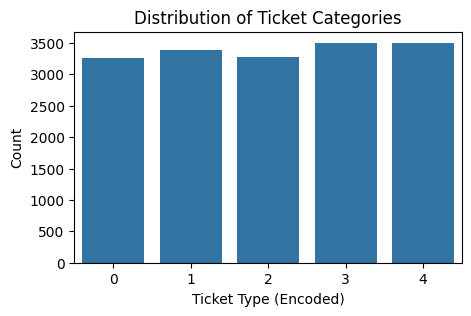

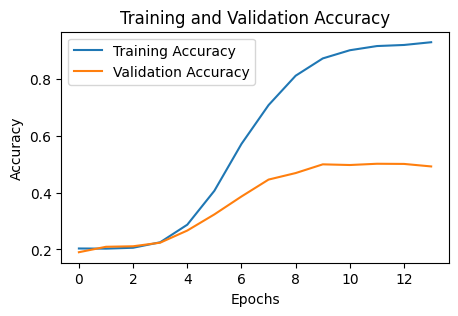

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Sample Ticket Classification: Refund request


In [ ]:
import pandas as pd
import numpy as np
import nltk
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = '/content/customer_support_tickets.csv'
df = pd.read_csv(file_path)

# Inspect and filter necessary columns
df = df[['Ticket Description', 'Ticket Type']].dropna()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

df['Ticket Description'] = df['Ticket Description'].apply(clean_text)

# Label encoding for target variable
le = LabelEncoder()
df['Ticket Type'] = le.fit_transform(df['Ticket Type'])

# Data Augmentation using synonym replacement with WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in nltk.corpus.wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.name() != word:
                synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

def augment_text(text):
    words = nltk.word_tokenize(text)
    augmented_text = words.copy()
    for _ in range(len(augmented_text) // 2):
        idx = random.randint(0, len(augmented_text) - 1)
        synonyms = get_synonyms(augmented_text[idx])
        if synonyms:
            augmented_text[idx] = random.choice(synonyms)
    return ' '.join(augmented_text)

df['Augmented Description'] = df['Ticket Description'].apply(augment_text)
df = pd.concat([df, df[['Augmented Description', 'Ticket Type']].rename(columns={'Augmented Description': 'Ticket Description'})])

# Tokenization and Padding for Neural Network
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['Ticket Description'])
X_seq = tokenizer.texts_to_sequences(df['Ticket Description'])
X_pad = pad_sequences(X_seq, maxlen=100)

# Split the data
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, df['Ticket Type'], test_size=0.2, random_state=42)

# Enhanced Neural Network Model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(le.classes_), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_pad, epochs=20, batch_size=64, validation_data=(X_test_pad, y_test_pad), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_pad)
print("Enhanced Neural Network Model Accuracy:", accuracy)

# Visualize the category distribution
plt.figure(figsize=(5, 3))
sns.countplot(x=df['Ticket Type'])
plt.title("Distribution of Ticket Categories")
plt.xlabel("Ticket Type (Encoded)")
plt.ylabel("Count")
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# Example Prediction Function
def nn_predict(description):
    description_seq = pad_sequences(tokenizer.texts_to_sequences([description.lower()]), maxlen=100)
    pred = np.argmax(model.predict(description_seq), axis=-1)[0]
    return le.inverse_transform([pred])[0]

# Example Usage
print("Sample Ticket Classification:", nn_predict("I need help with a refund"))
